# Lab | Imbalanced data
We will be using the files_for_lab/customer_churn.csv dataset to build a churn predictor.

## Instructions

1. Load the dataset and explore the variables.
2. We will try to predict variable Churn using a logistic regression on variables tenure, SeniorCitizen,MonthlyCharges.
3. Extract the target variable.
4. Extract the independent variables and scale them.
5. Build the logistic regression model.
6. Evaluate the model.
7. Even a simple model will give us more than 70% accuracy. Why?
8. *Synthetic Minority Oversampling TEchnique (SMOTE)* is an over sampling technique based on nearest neighbors that adds new points between existing points. Apply imblearn.over_sampling.SMOTE to the dataset. Build and evaluate the logistic regression model. Is it there any improvement?
9. Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process. Apply imblearn.under_sampling.TomekLinks to the dataset. Build and evaluate the logistic regression model. Is it there any improvement?

In [130]:
# Importing the libraries.
import pandas as pd        # Data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np         # Linear algebra
import seaborn as sns      # For data visualization
import re
import matplotlib.pyplot as plt      # For data visualization purposes
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
import warnings
warnings.filterwarnings('ignore')

### 1. Load the dataset and explore the variables.

In [50]:
# Loading the data from csv file.
data = pd.read_csv('/Users/pauli/Desktop/Ironhack/Week9/Sabado_24.09.2022/lab-imbalanced-data/files_for_lab/customer_churn.csv')

# Setting the display options.
pd.set_option('display.max_columns', None)

# Preview the dataset.
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [51]:
# Viewing dimensions of dataset.
data.shape

(7043, 21)

In [52]:
# Drop redundant columns from the dataset which does not have any predictive power. 
# In this case, customer_id is the redundant column. So, I will drop it first.
data.drop('customerID', axis=1, inplace=True)

In [53]:
# Renaming the columns so they follow the PE8 (snake case).
col = data.columns.values
new_col = []
for x in col:
    x = re.sub(r"(\w)([A-Z])", r"\1_\2", x).lower()
    new_col.append(x)
new_col
data.columns = new_col
data.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'churn'],
      dtype='object')

In [54]:
# Viewing the summary of dataset.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   senior_citizen     7043 non-null   int64  
 2   partner            7043 non-null   object 
 3   dependents         7043 non-null   object 
 4   tenure             7043 non-null   int64  
 5   phone_service      7043 non-null   object 
 6   multiple_lines     7043 non-null   object 
 7   internet_service   7043 non-null   object 
 8   online_security    7043 non-null   object 
 9   online_backup      7043 non-null   object 
 10  device_protection  7043 non-null   object 
 11  tech_support       7043 non-null   object 
 12  streaming_tv       7043 non-null   object 
 13  streaming_movies   7043 non-null   object 
 14  contract           7043 non-null   object 
 15  paperless_billing  7043 non-null   object 
 16  payment_method     7043 

* We can see that the *customerID* column has been removed from the dataset.

* We can see that there are 3 numerical variables: *senior_citizen*, *tenure*, *monthly_charges*, but there is one more unmerical variable: *total_charges*.

In [55]:
# Frequency distribution of values in variables.
for var in data.columns:
    print(data[var].value_counts())

Male      3555
Female    3488
Name: gender, dtype: int64
0    5901
1    1142
Name: senior_citizen, dtype: int64
No     3641
Yes    3402
Name: partner, dtype: int64
No     4933
Yes    2110
Name: dependents, dtype: int64
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64
Yes    6361
No      682
Name: phone_service, dtype: int64
No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64
Fiber optic    3096
DSL            2421
No             1526
Name: internet_service, dtype: int64
No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64
No                     3088
Yes                    2429
No internet service    1526
Name: online_backup, dtype: int64
No                     3095
Yes                    2422
No internet service    1526
Name: device_protection, dtype: int64
No     

* The distribution of values shows that data type of *total_charges* is of type **integer**. But the summary of the dataframe shows that it is type **object**. So, I will explicitly convert its data type to integer.

In [56]:
# Convert data type of total_charges to integer.
data['total_charges'] = pd.to_numeric(data['total_charges'], errors='coerce')

#### Missing values in variables.

In [57]:
# Checking the % of NaN values by column.
round((data.isna().sum()/len(data)*100),2)

gender               0.00
senior_citizen       0.00
partner              0.00
dependents           0.00
tenure               0.00
phone_service        0.00
multiple_lines       0.00
internet_service     0.00
online_security      0.00
online_backup        0.00
device_protection    0.00
tech_support         0.00
streaming_tv         0.00
streaming_movies     0.00
contract             0.00
paperless_billing    0.00
payment_method       0.00
monthly_charges      0.00
total_charges        0.16
churn                0.00
dtype: float64

* We can see that the total_charges column contains **0.16% NaN** values.

### 2. We will try to predict variable *Churn* using a logistic regression on variables *tenure*, *SeniorCitizen*, *MonthlyCharges*.

In [58]:
# Choose the columns we will have as our features.
features_list = ['tenure', 'senior_citizen', 'monthly_charges']

In [59]:
for x in features_list:
    print(x, len(data[x].unique()))

tenure 73
senior_citizen 2
monthly_charges 1585


In [60]:
# Viewing frequency distribution of values in the senior_citizen variable.
data.senior_citizen.value_counts()

0    5901
1    1142
Name: senior_citizen, dtype: int64

* We can see that the *senior_citizen* is a discrete variable that contains 2 class labels - 0 and 1.

### 3. Extract the target variable.

In [61]:
y= data.loc[:, "churn"]

# Viewing frequency distribution of values in the target variable.
data['churn'].value_counts()

No     5174
Yes    1869
Name: churn, dtype: int64

In [62]:
# Viewing the percentage of frequency distribution of values in 'class' variable.
round(data['churn'].value_counts()/np.float(len(data))*100, 2)

No     73.46
Yes    26.54
Name: churn, dtype: float64

* The target variable is imbalanced. An imbalanced dataset is a dataset where the number of data points per class differs drastically, resulting in a heavily biased machine learning model that won’t be able to learn the minority class (label Yes).

### 4. Extract the independent variables and scale them.

In [81]:
# Extracting the independent variables.
x=data.loc[:, features_list]
x.head()

,tenure,senior_citizen,monthly_charges
0,1,0,29.85
1,34,0,56.95
2,2,0,53.85
3,45,0,42.30
4,2,0,70.70


In [82]:
# Checking the type of the independent variables.
x.dtypes

tenure               int64
senior_citizen       int64
monthly_charges    float64
dtype: object

#### Outliers in independent variables.

In [83]:
# Viewing summary statistics in independent variables.
print(round(x.describe(),2).T)

                  count   mean    std    min   25%    50%    75%     max
tenure           7043.0  32.37  24.56   0.00   9.0  29.00  55.00   72.00
senior_citizen   7043.0   0.16   0.37   0.00   0.0   0.00   0.00    1.00
monthly_charges  7043.0  64.76  30.09  18.25  35.5  70.35  89.85  118.75


#### Encode numerical discrete data.

In [86]:
discrete_numeric_variable = pd.get_dummies(x['senior_citizen'], drop_first=True)
discrete_numeric_variable.head()

,1
0,0
1,0
2,0
3,0
4,0


* Normalizing dummy variables makes no sense.

#### Feature scaling.
The standard scaler is used **before** training the data. The idea behind StandardScaler is that it will transform the data such that its distribution will have a mean value 0 and standard deviation of 1.

In [92]:
# We will only use the continuous_numeric_variables.
x = x.drop('senior_citizen', axis=1)
x.head()

,tenure,monthly_charges
0,1,29.85
1,34,56.95
2,2,53.85
3,45,42.30
4,2,70.70


In [93]:
# To standardize numerical features we apply the Standard Scaler
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)

In [94]:
continuous_numeric_variables = pd.DataFrame(x_norm, columns=x.columns)
continuous_numeric_variables.head()

,tenure,monthly_charges
0,-1.277445,-1.160323
1,0.066327,-0.259629
2,-1.236724,-0.362660
3,0.514251,-0.746535
4,-1.236724,0.197365


In [97]:
X = pd.concat([discrete_numeric_variable, continuous_numeric_variables], axis=1)
X.head()

,1,tenure,monthly_charges
0,0,-1.277445,-1.160323
1,0,0.066327,-0.259629
2,0,-1.236724,-0.362660
3,0,0.514251,-0.746535
4,0,-1.236724,0.197365


* We now have **X** dataset ready to be fed into the Logistic Regression classifier.

### 5. Build the logistic regression model.

#### Train/test split review:
Train test split is a model validation procedure that allows you to simulate how a model would perform on new/unseen data "Train" is the majority of the you are "training" the model on (about 75%) "Test" is the rest of the data (about 25%) that you will use **after** making the model, to test your training model on to see how good the model is in predicting results.

In [98]:
# Here we start scaling, so need to divide dataset Train set & Test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=100)

* I use train_test_split test_size= 0.3, and this is completely arbitrary. 
* You choose whaveter proportion suits you.

In [99]:
# Checking the shape of X_train and X_test
X_train.shape, X_test.shape

((4930, 3), (2113, 3))

In [100]:
# Instantiating the model.
model = LogisticRegression(max_iter=300, multi_class='ovr', random_state=0)
model.fit(X_train, y_train)

# This steps is the actual training of the data using binomial classification model.

LogisticRegression(max_iter=300, multi_class='ovr', random_state=0)

### 6. Evaluate the model.


Now, we can visualize our results and evaluate our model. Visualizing in graph is optional because depending on your model, it will harder to build a 2D graph. However, we can always evaluate performance using a metric.

For regression, we often use 𝑅2. Let's do that using sklearn again. To evaluate our model, we will try to compare  𝑅2  on the train set and on the test set.

In [101]:
# Assessing the performances of the model:

r2_train_set = model.score(X_train, y_train)
print("R2 score on train  :", round(r2_train_set*100, 2), "%")

r2_test_set = model.score(X_test, y_test)
print("R2 score on test  :", round(r2_test_set*100, 2), "%")
# Print R^2 scores

R2 score on train  : 79.49 %
R2 score on test  : 77.99 %


Depending on the results, we will be able to tell if the model is performing well and whether it is overfitting or not.
- 𝑅2  close to 1 means good performance
- 𝑅2𝑡𝑟𝑎𝑖𝑛  >  𝑅2𝑡𝑒𝑠𝑡  means overfitting
- 𝑅2𝑡𝑟𝑎𝑖𝑛  <  𝑅2𝑡𝑒𝑠𝑡  means underfitting

### 7. Even a simple model will give us more than 70% accuracy. Why?

#### Classification report.

In [102]:
# Use model to make predictions on train data
predicted_y_train = model.predict(X_train)
print('\033[1m' + 'predicted_y_train' + '\033[0m')
print( classification_report(y_train, predicted_y_train))

# Use model to make predictions on test data
predicted_y_test = model.predict(X_test)
print('\033[1m' + 'predicted_y_test' + '\033[0m')

print(classification_report(y_test, predicted_y_test))
#classification_report(true_label, predicted)

predicted_y_train
              precision    recall  f1-score   support

          No       0.83      0.91      0.87      3627
         Yes       0.66      0.47      0.55      1303

    accuracy                           0.79      4930
   macro avg       0.74      0.69      0.71      4930
weighted avg       0.78      0.79      0.78      4930

predicted_y_test
              precision    recall  f1-score   support

          No       0.82      0.90      0.86      1547
         Yes       0.62      0.45      0.53       566

    accuracy                           0.78      2113
   macro avg       0.72      0.68      0.69      2113
weighted avg       0.77      0.78      0.77      2113



* We can observe that the imbalance is preserved on the test set.

#### Confusion Matrix to check the accuracy visually.
A confusion matrix is a tool for summarizing the performance of a classification algorithm. A confusion matrix will give us a clear picture of classification model performance and the types of errors produced by the model. It gives us a summary of correct and incorrect predictions broken down by each category. The summary is represented in a tabular form.

Four types of outcomes are possible while evaluating a classification model performance. These four outcomes are described below:-

**True Positives (TP)** – True Positives occur when we predict an observation belongs to a certain class and the observation actually belongs to that class.

**True Negatives (TN)** – True Negatives occur when we predict an observation does not belong to a certain class and the observation actually does not belong to that class.

**False Positives (FP)** – False Positives occur when we predict an observation belongs to a certain class but the observation actually does not belong to that class. This type of error is called Type I error.

**False Negatives (FN)** – False Negatives occur when we predict an observation does not belong to a certain class but the observation actually belongs to that class. This is a very serious error and it is called Type II error.

These four outcomes are summarized in a confusion matrix given below.

<AxesSubplot:>

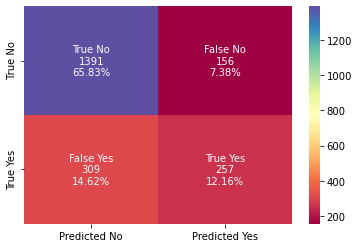

In [33]:
# Confusion Matrix on test set.
cm = confusion_matrix(y_test, predicted_y_test)
group_names = ['True No', 'False No', 'False Yes', 'True Yes']

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Spectral', xticklabels=["Predicted No", "Predicted Yes"], yticklabels=[" True No", "True Yes"])


The accuracy over 70% is obtained because the model is trained with a much higher number of *No* outcomes than *Yes*, and as such it predicts with very high accuracy the *No*.

However, as we can see in the confusion matrix and in the recall values, the model is quite good at predicting Churn labeled *No* but very bad at predicting Churn labeled *Yes*.

### 8. Synthetic Minority Oversampling TEchnique (SMOTE) 
is an over sampling technique based on nearest neighbors that adds new points between existing points. 
- Apply **imblearn.over_sampling.SMOTE** to the dataset. 
- Build and evaluate the logistic regression model. Is it there any improvement?

In [119]:
# I Assign new variables to "X" and y "y" to avoid overlap with previous model.
X_smote = X.copy()
y_smote = y.copy()
print(X_smote.shape)
print(y_smote.shape)

(7043, 3)
(7043,)


In [123]:
# Apply oversampling to X_train and y_train
smote = SMOTE(k_neighbors = 3, random_state = 100)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train,y_train)

In [122]:
y_train.value_counts() 

No     3627
Yes    1303
Name: churn, dtype: int64

In [124]:
# Here we can see that we create synthetic data.
y_train_SMOTE.value_counts()

No     3627
Yes    3627
Name: churn, dtype: int64

In [128]:
# Use model to make predictions on train data
pred_y_train_SMOTE = model.predict(X_train_SMOTE)
print('\033[1m' + 'pred_train_SMOTE' + '\033[0m')
print(classification_report(y_train_SMOTE, pred_y_train_SMOTE))

# Use model to make predictions on test data
pred_y_test_SMOTE = model.predict(X_test)
print('\033[1m' + 'pred_test_SMOTE' + '\033[0m')
print(classification_report(y_test, pred_y_test_SMOTE))

pred_train_SMOTE
              precision    recall  f1-score   support

          No       0.63      0.91      0.74      3627
         Yes       0.84      0.46      0.59      3627

    accuracy                           0.69      7254
   macro avg       0.73      0.69      0.67      7254
weighted avg       0.73      0.69      0.67      7254

pred_test_SMOTE
              precision    recall  f1-score   support

          No       0.82      0.90      0.86      1547
         Yes       0.62      0.45      0.53       566

    accuracy                           0.78      2113
   macro avg       0.72      0.68      0.69      2113
weighted avg       0.77      0.78      0.77      2113



### 9. Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process. Apply imblearn.under_sampling.TomekLinks to the dataset. Build and evaluate the logistic regression model. Is it there any improvement?

In [129]:
X_tom = X.copy()
y_tom = y.copy()

In [132]:
# Apply undersampling to X_train and y_train.

tl = TomekLinks('majority')
X_train_tl, y_train_tl = tl.fit_resample(X_train, y_train)
display(y_train_tl.value_counts())

No     3287
Yes    1303
Name: churn, dtype: int64